In [1]:
import pickle
import time
import numpy as np
import sys
from tkinter import *
import pylab
import math
import random as rand
import time
import tkinter as tk
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import random
from collections import deque

In [2]:
FONT = ("Verdana", 40, "bold")
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3

ACTION_STRING = {LEFT : 'left', UP:'up' , RIGHT:'right', DOWN:'down'}
class Env(tk.Tk):
    def __init__(self, width =4, height =4):
        super(Env, self).__init__()
        self.width = width
        self.height = height
        self.board = None
        self.score = 0
        ###
        self.title('2048')
        self.geometry('{0}x{1}'.format(700, 800))
        self.SIZE = 500
        self.GRID_LEN = 4
        self.GRID_PADDING = 10
        self.BACKGROUND_COLOR_GAME = "#92877d"
        self.BACKGROUND_COLOR_CELL_EMPTY = "#9e948a"
        self.BACKGROUND_COLOR_DICT = {2: "#eee4da", 4: "#ede0c8", 8: "#f2b179", 16: "#f59563",
                                      32: "#f67c5f", 64: "#f65e3b", 128: "#edcf72", 256: "#edcc61",
                                      512: "#edc850", 1024: "#edc53f", 2048: "#edc22e"}

        self.CELL_COLOR_DICT = {2: "#776e65", 4: "#776e65", 8: "#f9f6f2", 16: "#f9f6f2",
                                32: "#f9f6f2", 64: "#f9f6f2", 128: "#f9f6f2", 256: "#f9f6f2",
                                512: "#f9f6f2", 1024: "#f9f6f2", 2048: "#f9f6f2"}
        self.grid_cells = []
        self.init_grid()
        self.init_matrix()
        self.action_size = len(ACTION_STRING)
        self.wait_visibility()
        

    def init_grid(self):
        self.background = tk.Frame(self, bg=self.BACKGROUND_COLOR_GAME, width=self.SIZE, height=self.SIZE)
        self.background.grid()
        for i in range(self.GRID_LEN):
            self.grid_row = []
            for j in range(self.GRID_LEN):
                self.cell = tk.Frame(self.background, bg=self.BACKGROUND_COLOR_CELL_EMPTY,
                                     width=self.SIZE / self.GRID_LEN, height=self.SIZE / self.GRID_LEN)
                self.cell.grid(row=i, column=j, padx=self.GRID_PADDING, pady=self.GRID_PADDING)
                # font = Font(size=FONT_SIZE, family=FONT_FAMILY, weight=FONT_WEIGHT)
                t = Label(master=self.cell, text="", bg=self.BACKGROUND_COLOR_CELL_EMPTY, justify=CENTER, font=FONT,
                          width=4, height=2)
                t.grid()
                self.grid_row.append(t)

            self.grid_cells.append(self.grid_row)
        self.grid_row = []
        self.cell = tk.Frame(self.background, bg=self.BACKGROUND_COLOR_CELL_EMPTY, width=self.SIZE,
                             height=self.SIZE / self.GRID_LEN)
        self.cell.grid(row=4, columnspan=4, padx=self.GRID_PADDING, pady=self.GRID_PADDING, sticky=W + E + N + S)
        t = Label(master=self.cell, text="", bg=self.BACKGROUND_COLOR_CELL_EMPTY, justify=CENTER, font=FONT, width=4,
                  height=2)
        t.grid(columnspan=4, ipadx=250)
        self.grid_row.append(t)
        self.grid_cells.append(self.grid_row)

    def init_matrix(self):
        self.reset()

    def reset(self):
        self.board = np.zeros((self.width,self.height),dtype = np.int64)
        self.place_random_tiles(self.board,cnt=2)
        self.score = 0
        return self.board
        
    def render(self):
        time.sleep(0.01)
        self.update()
    
    def close(self):
        self.destroy()
        
    def canMove(self, action:int, state):
        state = state.reshape((4,4))
        rotated_obs = np.rot90(state, k=action)
        reward, updated_obs = self.slide_left_and_merge(rotated_obs)
        bord = np.rot90(updated_obs, k=4 - action).reshape(1,-1)
        return bord
    
    def canMove_t(self, action:int, state):
        state_ = state.to('cpu').numpy().copy()[0][0]
        state.to('cuda')
        rotated_obs = np.rot90(state_, k=action)
        reward, updated_obs = self.slide_left_and_merge(rotated_obs)
        bord = np.rot90(updated_obs, k=4 - action)
        return state_.reshape(-1,16), bord.reshape(-1,16)
    
    def step(self, action:int):
        rotated_obs = np.rot90(self.board, k=action)
        reward, updated_obs = self.slide_left_and_merge(rotated_obs)
        self.board = np.rot90(updated_obs, k=4 - action)
        
        self.place_random_tiles(self.board, cnt=1)
        done = self.is_done()
        self.score += reward
        for i in range(self.GRID_LEN):
            for j in range(self.GRID_LEN):
                new_number = self.board[i][j]
                if new_number == 0:
                    self.grid_cells[i][j].configure(text="", bg=self.BACKGROUND_COLOR_CELL_EMPTY)
                else:
                    self.grid_cells[i][j].configure(text=str(new_number), bg=self.BACKGROUND_COLOR_DICT[new_number],
                                                    fg=self.CELL_COLOR_DICT[new_number])
        self.grid_cells[4][0].configure(text="Game Score : {}".format(self.score),
                                        bg=self.BACKGROUND_COLOR_CELL_EMPTY, justify=CENTER)
        if done:
            self.grid_cells[1][1].configure(text="You", bg=self.BACKGROUND_COLOR_CELL_EMPTY)
            self.grid_cells[1][2].configure(text="Lose!", bg=self.BACKGROUND_COLOR_CELL_EMPTY)
            
        return self.board, reward,done,{}
    
    def is_done(self):
        temp = self.board.copy()
        if not temp.all():
            return False
        
        for action in range(4):
            rotated_obs = np.rot90(temp,k=action)
            _,updated_obs = self.slide_left_and_merge(rotated_obs)
            if not updated_obs.all():
                return False
        
        return True
            
            
        
    def sample_tiles(self, cnt=1):

        choices = [2, 4]
        probs = [0.9, 0.1]

        tiles = np.random.choice(choices,size=cnt, p=probs)
        return tiles.tolist()

    def place_random_tiles(self,board,cnt =1):
        if not board.all():
            tiles = self.sample_tiles(cnt)
            tile_locations = self.sample_tile_locations(board, cnt)
            board[tuple(tile_locations)] = tiles
    
    def sample_tile_locations(self, board, cnt=1):
        zero_locations = np.argwhere(board==0)
        zero_index = np.random.choice(len(zero_locations) , size = cnt)
        
        zero_position = zero_locations[zero_index]
        zero_position = list(zip(*zero_position))
        
        return zero_position
    
    
    def slide_left_and_merge(self, board):
        result=[]
        score = 0
        for row in board:
            row = np.extract(row>0,row)
            score_, result_row = self.try_merge(row)
            
            score+= score_
            row = np.pad(np.array(result_row), (0, self.width - len(result_row)), 'constant', constant_values=(0,))
            result.append(row)
            
        return score, np.array(result, dtype=np.int64)
    
    @staticmethod
    def try_merge(row):
        score = 0
        result_row = []
        i=1
        while i <len(row):
            if row[i] == row[i-1]:
                score += row[i]*2
                result_row.append(row[i]*2)
                i+=2
            else:
                result_row.append(row[i-1])
                i+=1
        if i==len(row):
            result_row.append(row[i-1])
        return score, result_row

In [3]:
class DQNAgent:
    def __init__(self,state_size,action_size, load_model):
        self.load_model = load_model
        self.train_loss = 0
        self.render = True
        self.discount_factor = 0.99
        self.learning_rate = 0.00005
        
        self.epsilon = 1.0
        self.epsilon_decay=0.99999
        self.epsilon_min = 0.10
        
        self.batch_size = 1024
        self.train_start = 1024

        self.queueLenMax = 5000
        self.memory = deque(maxlen = self.queueLenMax)
        
        self.perfWindowSize =10
        self.penalty = -100
        
        
        self.state_size = state_size
        self.action_size = action_size

        self.model ,self.model_optim, self.model_loss= self.build_model()
        self.target_model,self.target_model_optim,self.target_model_loss = self.build_model()
    
        self.update_target_model() # set same weights at the first time
        
        if self.load_model:
            self.model.load_state_dict(torch.load("./save_model/2048_dqn_trained.pth"))
            self.epsilon_decay =1 
            self.epsilon = 0
            self.epsilon_min = 0
            print('Model_loaded...')

    def change_values(X):
        power_mat = np.zeros(shape=(1,4,4,16),dtype=np.float32)
        for i in range(4):
            for j in range(4):
                if(X[i][j]==0):
                    power_mat[0][i][j][0] = 1.0
                else:
                    power = int(math.log(X[i][j],2))
                    power_mat[0][i][j][power] = 1.0
        return power_mat    
    
    def build_model(self):
        
        model = nn.Sequential(nn.Conv2d(1,16, kernel_size=2,stride=1),
                              nn.ReLU(),
                              nn.Conv2d(16,32, kernel_size=2,stride=1),
                              nn.ReLU(),
                              nn.Conv2d(32,64, kernel_size=2,stride=1),
                              nn.ReLU(),
                              nn.Flatten(),
                              nn.Linear(64,128),
                              nn.ReLU(),
                              nn.Linear(128,16),
                              nn.ReLU(),
                              nn.Linear(16,4))
        model.to('cuda')
        optimizer = torch.optim.Adam(model.parameters(), lr = self.learning_rate)
        loss = nn.MSELoss()

        return model,optimizer,loss
    
    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())
        
    
    def get_action(self, state, env):
        if np.random.rand() <= self.epsilon:
            legal_moves = list()
            for i in range(4):
                temp_board = env.canMove(i, state)
                if(np.array_equal(temp_board,state)):
                    continue
                else:
                    legal_moves.append(i)
            return random.choice(legal_moves)
        else:
            state = torch.tensor([state],dtype =torch.float32).reshape(-1,1,4,4).to('cuda')
            state_ = state.clone()
            state_[state_ == 0] = 1.
            q_value = self.model(torch.log2(state_))
            q_value = q_value.cpu().detach().numpy()
            legal_moves = list()
            for i in range(4):
                state_, temp_board = env.canMove_t(i, state)
                if np.array_equal(temp_board,state_):
                    continue
                else:
                    legal_moves.append(i)
            while np.argmax(q_value[0]) not in legal_moves:
                q_value[0][np.argmax(q_value[0])] = -np.inf
                if len(legal_moves) == 0:
                    break
                continue
            return np.argmax(q_value[0])
        
    def append_sample(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

            
    def train_model(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        else:
            self.epsilon = self.epsilon_min
            
        mini_batch = random.sample(self.memory, self.batch_size)

        states = np.zeros((self.batch_size, self.state_size))
        next_states = np.zeros((self.batch_size, self.state_size))
        actions, rewards, dones = [], [], []

        for i in range(self.batch_size):
            states[i] = mini_batch[i][0]
            actions.append(mini_batch[i][1])
            rewards.append(mini_batch[i][2])
            next_states[i] = mini_batch[i][3]
            dones.append(mini_batch[i][4])
    
        
        states = torch.tensor(states, dtype =torch.float32).reshape(-1,1,4,4).to('cuda')
        states[states==0] = 1.
        next_states = torch.tensor(next_states,dtype =torch.float32).reshape(-1,1,4,4).to('cuda')
        next_states[next_states==0] = 1.
        
        target = self.model(torch.log2(states))
        target_val = self.target_model(torch.log2(next_states))
    
        target_val = target_val.cpu().detach().numpy()
        
        for i in range(self.batch_size):
            if dones[i]:
                target[i][actions[i]] = rewards[i]
            else:
                target[i][actions[i]] = rewards[i] + self.discount_factor * (np.amax(target_val[i]))

        # and do the model fit!
        self.model.train()
        self.model_optim.zero_grad()
        
        output = self.model(torch.log2(states))
        loss = self.model_loss(output,target)
        loss.backward()
        self.train_loss += loss.item()
        self.model_optim.step()
        
      

episode: 0   score: 1104  move: 118   memory length: 118   epsilon: 1.0  loss: 0.0
Weights save... Top reward = 168
episode: 1   score: 1636  move: 166   memory length: 284   epsilon: 1.0  loss: 0.0
episode: 2   score: 448  move: 65   memory length: 349   epsilon: 1.0  loss: 0.0
episode: 3   score: 916  move: 99   memory length: 448   epsilon: 1.0  loss: 0.0
episode: 4   score: 1076  move: 116   memory length: 564   epsilon: 1.0  loss: 0.0
episode: 5   score: 3040  move: 250   memory length: 814   epsilon: 1.0  loss: 0.0
Weights save... Top reward = 260
episode: 6   score: 724  move: 90   memory length: 904   epsilon: 1.0  loss: 0.0
episode: 7   score: 1604  move: 158   memory length: 1062   epsilon: 0.9996100740908634  loss: 29.85304211966599
episode: 8   score: 932  move: 116   memory length: 1178   epsilon: 0.998451192891553  loss: 156.13477739794502
episode: 9   score: 792  move: 97   memory length: 1275   epsilon: 0.9974831599661506  loss: 286.7746789676627
episode: 10   score: 57

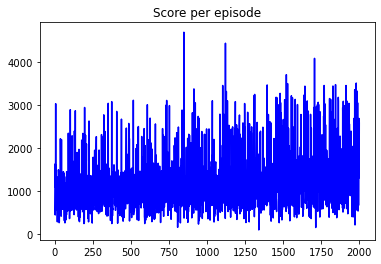

In [32]:
if __name__ == '__main__':
    env = Env()
    state_size = 16
    action_size = 4
    load_model = False
    agent = DQNAgent(state_size, action_size, load_model)
    Top = -np.inf
    scores, episodes = [], []
    lossss = []
    EPISODES=2000
    for e in range(EPISODES):
        done=False
        score = 0
        state = env.reset()
        state = np.reshape(state, [1, state_size])
        maxScore = -np.inf
        move =0
        while not done:
#             if agent.render:
#             print(env.render())
            move+=1
            # get action for the current state and go one step in environment
            action = agent.get_action(state, env)
#             print(np.array(env.board))
            next_state, reward, done, info = env.step(action)
            next_state = np.reshape(next_state, [1, state_size])
            # if an action make the episode end, then gives penalty of -100
#             reward = reward if not done or score == 499 else agent.penalty
#             print({0 : 'left', 1:'up' , 2:'right', 3:'down'}[action])
            # save the sample <s, a, r, s'> to the replay memory
            agent.append_sample(state, action, reward, next_state, done)
            # every time step do the training
            if agent.load_model is False and (len(agent.memory) >= agent.train_start):
                agent.train_model()
                
            score += reward
            state = next_state
            if(reward > maxScore):
                maxScore = reward
            if done:
                # every episode update the target model to be same with model
                if agent.load_model is False:
                    agent.update_target_model()
                lossss.append(agent.train_loss/move)
                # every episode, plot the play time
#                 score = score if score == 500 else score + 100
                scores.append(score)
                episodes.append(e)
                print("episode:", e, "  score:", score, " move:", move,"  memory length:", len(agent.memory), "  epsilon:", agent.epsilon, ' loss:', agent.train_loss/move)
                if (maxScore > Top) and not (load_model):
                        Top = maxScore
                        print('Weights save... Top reward = {}'.format(maxScore))
                        torch.save(agent.model.state_dict(), './save_model/2048_dqn_trained.pth')
    pylab.plot(episodes, scores, 'b')
    pylab.title('Score per episode')
    pylab.savefig('save_plt/Learning_rate={},epsilon_min={},Discount_factor={},episod={}.png'.format(agent.learning_rate, agent.epsilon_min, agent.discount_factor, e+1), dpi=300, facecolor='w')

         

# Test

Model_loaded...
Top reward = 256
episode: 0   score: 3844  move: 312   memory length: 312   epsilon: 0  loss: 0.0
Top reward = 136
episode: 1   score: 1616  move: 178   memory length: 490   epsilon: 0  loss: 0.0
Top reward = 72
episode: 2   score: 796  move: 101   memory length: 591   epsilon: 0  loss: 0.0
Top reward = 192
episode: 3   score: 2296  move: 214   memory length: 805   epsilon: 0  loss: 0.0
Top reward = 260
episode: 4   score: 3524  move: 282   memory length: 1087   epsilon: 0  loss: 0.0
Top reward = 524
episode: 5   score: 4800  move: 333   memory length: 1420   epsilon: 0  loss: 0.0
Top reward = 556
episode: 6   score: 5348  move: 369   memory length: 1789   epsilon: 0  loss: 0.0
Top reward = 256
episode: 7   score: 2436  move: 209   memory length: 1998   epsilon: 0  loss: 0.0
Top reward = 128
episode: 8   score: 2112  move: 209   memory length: 2207   epsilon: 0  loss: 0.0
Top reward = 256
episode: 9   score: 4028  move: 334   memory length: 2541   epsilon: 0  loss: 0.0


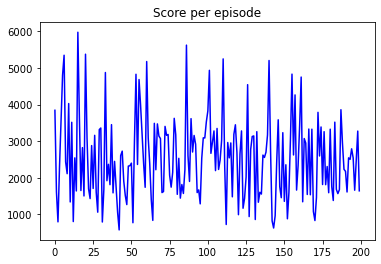

In [4]:
if __name__ == '__main__':
    env = Env()
    state_size = 16
    action_size = 4
    load_model = True
    agent = DQNAgent(state_size, action_size, load_model)
    Top = -np.inf
    scores, episodes = [], []
    lossss = []
    EPISODES=200
    for e in range(EPISODES):
        done=False
        score = 0
        state = env.reset()
        state = np.reshape(state, [1, state_size])
        maxScore = -np.inf
        move =0
        while not done:
#             if agent.render:
            env.render()
            move+=1
            # get action for the current state and go one step in environment
            action = agent.get_action(state, env)
#             print(np.array(env.board))
            next_state, reward, done, info = env.step(action)
            next_state = np.reshape(next_state, [1, state_size])
            # if an action make the episode end, then gives penalty of -100
#             reward = reward if not done or score == 499 else agent.penalty
#             print({0 : 'left', 1:'up' , 2:'right', 3:'down'}[action])
            # save the sample <s, a, r, s'> to the replay memory
            agent.append_sample(state, action, reward, next_state, done)
            # every time step do the training
            if (load_model is False) and (len(agent.memory) >= agent.train_start):
                agent.train_model()
                
            score += reward
            state = next_state
            if(reward > maxScore):
                maxScore = reward
            if done:
                # every episode update the target model to be same with model
                if load_model is False:
                    agent.update_target_model()
                print('Top reward = {}'.format(maxScore))
                lossss.append(agent.train_loss/move)
                # every episode, plot the play time
#                 score = score if score == 500 else score + 100
                scores.append(score)
                episodes.append(e)
                print("episode:", e, "  score:", score, " move:", move,"  memory length:", len(agent.memory), "  epsilon:", agent.epsilon, ' loss:', agent.train_loss/move)
                if (maxScore > Top) and not (load_model):
                        Top = maxScore
                        print('Weights save... Top reward = {}'.format(maxScore))
                        torch.save(agent.model.state_dict(), './save_model/2048_dqn_trained.pth')
    env.close()
    pylab.plot(episodes, scores, 'b')
    pylab.title('Score per episode')
#     pylab.savefig('save_plt/Learning_rate={},epsilon_min={},Discount_factor={},episod={}.png'.format(agent.learning_rate, agent.epsilon_min, agent.discount_factor, e+1), dpi=300, facecolor='w')


In [7]:
pylab.savefig('1st_model_512.png', dpi=300, facecolor='w')

<Figure size 432x288 with 0 Axes>